# Частина 1 — Імпорти, константи та завантаження CSV

In [7]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import gensim
from gensim.utils import simple_preprocess

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

train_df = pd.read_csv("./Corona_NLP_train.csv", encoding="latin1")
test_df = pd.read_csv("./Corona_NLP_test.csv", encoding="latin1")

print(train_df.head())
print(test_df.head())
print("Колонки:", list(train_df.columns))

print("Колонки:", list(test_df.columns))


   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3        

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Частина 2 — Визначення колонок з текстом та міткою, та функція очистки і токенізації

In [8]:
text_candidates = [
    'Original Tweet', 'OriginalTweet', 'tweet', 'text', 'Tweet',
    'Tweet At', 'Original_Tweet', 'TweetAt'
]

label_candidates = ['Sentiment', 'SentimentText', 'Label', 'label', 'Sentiment ']

# ===== Функція визначення колонки =====
def find_column(df, candidates, column_type="текстової/label"):
    for cand in candidates:
        if cand in df.columns:
            return cand
    raise ValueError(f"Не знайдено {column_type} колонки у CSV. Є такі: {', '.join(df.columns)}")

TEXT_COL = find_column(train_df, text_candidates, "текстової")

# === Шукаємо колонку мітки ===
try:
    LABEL_COL = find_column(train_df, label_candidates, "колонки мітки")
except:
    if 'Sentiment' in train_df.columns:
        LABEL_COL = 'Sentiment'
    else:
        raise ValueError("Не знайдено колонку мітки (Sentiment).")


print("Текстова колонка:", TEXT_COL)
print("Колонка мітки:", LABEL_COL)

STOP_WORDS = set(stopwords.words('english'))

def preprocess_to_tokens(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\brt\b', ' ', text)
    text = text.replace('#', ' ')
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = simple_preprocess(text, deacc=True, min_len=2)
    tokens = [t for t in tokens if t not in STOP_WORDS]
    return tokens

print(preprocess_to_tokens("RT @user: COVID-19 is terrible! Visit http://x.com #pandemic"))


Текстова колонка: OriginalTweet
Колонка мітки: Sentiment
['covid', 'terrible', 'visit', 'pandemic']


# Частина 3 — Токенізуємо всі твіти і закодуємо мітки (LabelEncoder)

In [9]:
train_df['tokens'] = train_df[TEXT_COL].progress_apply(preprocess_to_tokens)
test_df['tokens']  = test_df[TEXT_COL].progress_apply(preprocess_to_tokens)

train_df = train_df[train_df['tokens'].map(len) > 0].reset_index(drop=True)
test_df  = test_df[test_df['tokens'].map(len) > 0].reset_index(drop=True)


print("Train розмір після фільтрації:", train_df.shape)
print("Test  розмір після фільтрації:", test_df.shape)

# Label encoding
all_labels = pd.concat([
    train_df[LABEL_COL].astype(str),
    test_df[LABEL_COL].astype(str)
]).values

le = LabelEncoder()
le.fit(all_labels)

# Тепер застосовуємо до обох датасетів
train_df['y'] = le.transform(train_df[LABEL_COL].astype(str))
test_df['y']  = le.transform(test_df[LABEL_COL].astype(str))

print("Класи (мітки):", list(le.classes_))

# баланс класів
print("Баланс класів у TRAIN:")
display(train_df['y'].value_counts().rename(index=lambda i: le.inverse_transform([i])[0]))

print("Баланс класів у TEST:")
display(test_df['y'].value_counts().rename(index=lambda i: le.inverse_transform([i])[0]))


100%|███████████████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 17585.19it/s]

Train розмір після фільтрації: (41122, 7)
Test  розмір після фільтрації: (3796, 7)
Класи (мітки): ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
Баланс класів у TRAIN:


y
Positive              11420
Negative               9916
Neutral                7681
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

Баланс класів у TEST:


y
Negative              1041
Positive               947
Neutral                617
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

# Частина 4 — Реалізуємо Word2VecTransformer (sklearn-совісний трансформер)


In [10]:
class W2VTransformer(BaseEstimator, TransformerMixin):
    """
    Тренує gensim Word2Vec на вхідних документах (списках токенів або сирому тексті).
    Повертає для кожного документа вектор розміру vector_size (середнє векторів слів).
    """
    def __init__(self, vector_size=200, window=5, min_count=2, epochs=5, sg=0, workers=1, tokens_attr='tokens'):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.sg = sg
        self.workers = workers
        self.tokens_attr = tokens_attr  # якщо X містить списки токенів у колонці tokens
        self.model_ = None
        self.wv_ = None

    def fit(self, X, y=None):
        # Очікуємо X — ітерабельну колекцію документів (рядки або списки токенів). Якщо вхід — Series із raw-text,
        # спробуємо токенізувати. Якщо елементи — списки, беремо їх напряму.
        sentences = []
        for doc in X:
            if isinstance(doc, str):
                toks = preprocess_to_tokens(doc)
            elif isinstance(doc, (list, tuple)):
                toks = list(doc)
            else:
                toks = []
            if len(toks) > 0:
                sentences.append(toks)
        # Тренуємо модель
        if len(sentences) == 0:
            raise ValueError("Немає речень для тренування Word2Vec")
        self.model_ = gensim.models.Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            epochs=self.epochs
        )
        self.wv_ = self.model_.wv
        return self

    def transform(self, X):
        # Повертає масив shape=(len(X), vector_size)
        n = len(X)
        out = np.zeros((n, self.vector_size), dtype=float)
        for i, doc in enumerate(X):
            if isinstance(doc, str):
                toks = preprocess_to_tokens(doc)
            elif isinstance(doc, (list, tuple)):
                toks = list(doc)
            else:
                toks = []
            vecs = [self.wv_[w] for w in toks if w in self.wv_]
            if vecs:
                out[i, :] = np.mean(vecs, axis=0)
            else:
                out[i, :] = np.zeros(self.vector_size)
        return out

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)


# Частина 5 — Розділимо дані на train/test із стратифікацією


In [11]:
# X і y для тренувального набору
X_train = train_df[TEXT_COL].values
y_train = train_df['y'].values

# X і y для тестового набору
X_test = test_df[TEXT_COL].values
y_test = test_df['y'].values

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 41122
Test size: 3796


# Частина 6 — Навчаємо 4 моделі (LogReg, SVM, RandomForest, NaiveBayes) для кожного PCA-випадку


In [12]:
classifiers = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "LinearSVM": SVC(kernel='linear', probability=False, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1),
    "GaussianNB": GaussianNB()
}

# Варіанти PCA
pca_options = [None, 50, 100, 200]

# Розмір ембедингу
EMBED_DIM = 200

results = []

def make_pipeline(clf, pca_n):
    steps = []
    steps.append(('w2v', W2VTransformer(vector_size=EMBED_DIM, epochs=7, workers=1)))
    if pca_n is not None:
        steps.append(('pca', PCA(n_components=pca_n, random_state=RANDOM_STATE)))
    steps.append(('clf', clf))
    return Pipeline(steps)

for pca_n in pca_options:
    for name, clf in classifiers.items():
        print(f"Навчаємо: {name} | PCA={pca_n}")
        pipe = make_pipeline(clf, pca_n)

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'model': name,
            'pca_n': 'None' if pca_n is None else pca_n,
            'accuracy': acc,
            'report': report,
            'confusion_matrix': cm,
            'pipeline': pipe 
        })

        fname = f"pipeline_{name}_pca_{'None' if pca_n is None else pca_n}.joblib"
        joblib.dump(pipe, fname)
        print(f"Збережено {fname} | accuracy={acc:.4f}")


Навчаємо: LogReg | PCA=None
Збережено pipeline_LogReg_pca_None.joblib | accuracy=0.3962
Навчаємо: LinearSVM | PCA=None
Збережено pipeline_LinearSVM_pca_None.joblib | accuracy=0.3872
Навчаємо: RandomForest | PCA=None
Збережено pipeline_RandomForest_pca_None.joblib | accuracy=0.3783
Навчаємо: GaussianNB | PCA=None
Збережено pipeline_GaussianNB_pca_None.joblib | accuracy=0.2990
Навчаємо: LogReg | PCA=50
Збережено pipeline_LogReg_pca_50.joblib | accuracy=0.3730
Навчаємо: LinearSVM | PCA=50
Збережено pipeline_LinearSVM_pca_50.joblib | accuracy=0.3612
Навчаємо: RandomForest | PCA=50
Збережено pipeline_RandomForest_pca_50.joblib | accuracy=0.3807
Навчаємо: GaussianNB | PCA=50
Збережено pipeline_GaussianNB_pca_50.joblib | accuracy=0.3195
Навчаємо: LogReg | PCA=100
Збережено pipeline_LogReg_pca_100.joblib | accuracy=0.3962
Навчаємо: LinearSVM | PCA=100
Збережено pipeline_LinearSVM_pca_100.joblib | accuracy=0.3830
Навчаємо: RandomForest | PCA=100
Збережено pipeline_RandomForest_pca_100.joblib | 

# Частина 7 — Зберемо метрики у DataFrame і побудуємо графік accuracy vs PCA


f1                                         \
class              Extremely Negative Extremely Positive  Negative   Neutral   
model        pca_n                                                             
GaussianNB   50              0.353333           0.408385  0.222222  0.385704   
             100             0.359649           0.413553  0.213191  0.356478   
             200             0.361913           0.415537  0.196605  0.359352   
             None            0.365180           0.396040  0.122008  0.399023   
LinearSVM    50              0.003328           0.257028  0.384064  0.435484   
             100             0.154066           0.290862  0.385364  0.463492   
             200             0.160458           0.296774  0.393548  0.462145   
             None            0.160689           0.296774  0.394107  0.462145   
LogReg       50              0.261818           0.357224  0.359420  0.426606   
             100             0.302243           0.381166  0.375669  0.467359   
             200             0.305164           0.386083  0.379512  0.466568   
             None            0.296209           0.385218  0.376826  0.467013   
RandomForest 50              0.298122           0.347625  0.374763  0.438776   
             100             0.285366           0.340376  0.400187  0.454951   
             200             0.270754           0.302267  0.376973  0.453965   
             None            0.328228           0.354037  0.357777  0.460237   

                                      precision                               \
class               Positive Extremely Negative Extremely Positive  Negative   
model        pca_n                                                             
GaussianNB   50     0.248927           0.263245           0.381713  0.347648   
             100    0.242790           0.252740           0.431159  0.347826   
             200    0.231322           0.242915           0.452756  0.372654   
             None   0.137441           0.266254           0.287879  0.311024   
LinearSVM    50     0.415162           0.111111           0.648649  0.359598   
             100    0.429685           0.495413           0.634831  0.372093   
             200    0.431928           0.528302           0.653409  0.378211   
             None   0.431343           0.533333           0.653409  0.378426   
LogReg       50     0.398406           0.463519           0.560714  0.361516   
             100    0.412245           0.501961           0.580205  0.380671   
             200    0.415817           0.500000           0.589041  0.385530   
             None   0.411909           0.496032           0.585034  0.382034   
RandomForest 50     0.397223           0.488462           0.568182  0.370197   
             100    0.418011           0.513158           0.573123  0.390668   
             200    0.413169           0.554974           0.615385  0.364780   
             None   0.385098           0.465839           0.465940  0.348182   

                                                   recall                     \
class                Neutral  Positive Extremely Negative Extremely Positive   
model        pca_n                                                             
GaussianNB   50     0.356749  0.296784           0.537162           0.439065   
             100    0.319231  0.332721           0.623311           0.397329   
             200    0.329285  0.361798           0.709459           0.383973   
             None   0.400982  0.272727           0.581081           0.634391   
LinearSVM    50     0.433387  0.315414           0.001689           0.160267   
             100    0.454121  0.331236           0.091216           0.188648   
             200    0.450077  0.333910           0.094595           0.191987   
             None   0.450077  0.333526           0.094595           0.191987   
LogReg       50     0.403763  0.319898           0.182432           0.262104   
             100    0.430917  0.3

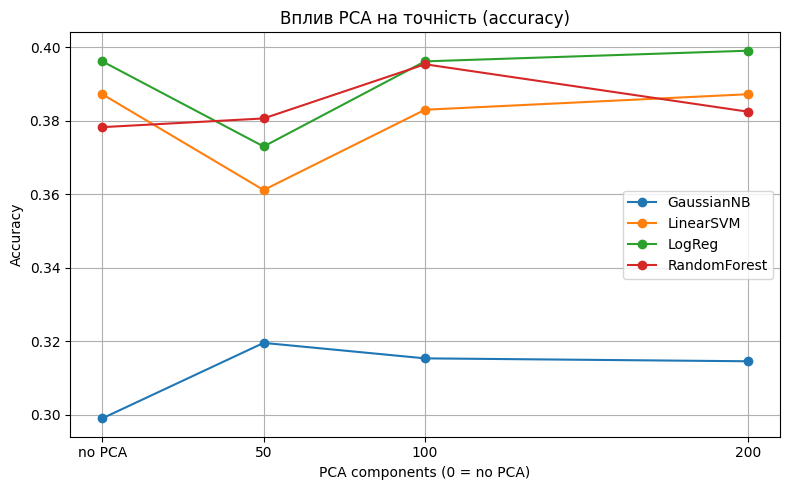

In [13]:
rows = []
for r in results:
    acc = r['accuracy']
    rep = r['report']
    macro_f1 = rep.get('macro avg', {}).get('f1-score', None)
    for cls in le.classes_:
        cls_prec = rep.get(cls, {}).get('precision', None)
        cls_rec = rep.get(cls, {}).get('recall', None)
        cls_f1 = rep.get(cls, {}).get('f1-score', None)
        rows.append({
            'model': r['model'],
            'pca_n': r['pca_n'],
            'accuracy': acc,
            'macro_f1': macro_f1,
            'class': cls,
            'precision': cls_prec,
            'recall': cls_rec,
            'f1': cls_f1
        })

metrics_df = pd.DataFrame(rows)
# Зведена таблиця precision/recall/f1 по класах
metrics_pivot = metrics_df.pivot_table(index=['model','pca_n'], columns='class', values=['precision','recall','f1'])
display(metrics_pivot)

# Графік accuracy vs PCA
acc_df = metrics_df.groupby(['model','pca_n'])['accuracy'].first().reset_index()
# перетворимо pca_n для сортування
def pca_to_int(x):
    return 0 if x=='None' else int(x)
acc_df['pca_plot'] = acc_df['pca_n'].apply(pca_to_int)
plt.figure(figsize=(8,5))
for model in acc_df['model'].unique():
    dfm = acc_df[acc_df['model']==model].copy().sort_values('pca_plot')
    plt.plot(dfm['pca_plot'], dfm['accuracy'], marker='o', label=model)
plt.xticks([0,50,100,200], labels=['no PCA','50','100','200'])
plt.xlabel("PCA components (0 = no PCA)")
plt.ylabel("Accuracy")
plt.title("Вплив PCA на точність (accuracy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Частина 8 — Знайдемо найкращу модель за accuracy і виведемо confusion matrix + classification_report


Найкраща модель: LogReg | PCA: 200 | accuracy: 0.39910432033719706


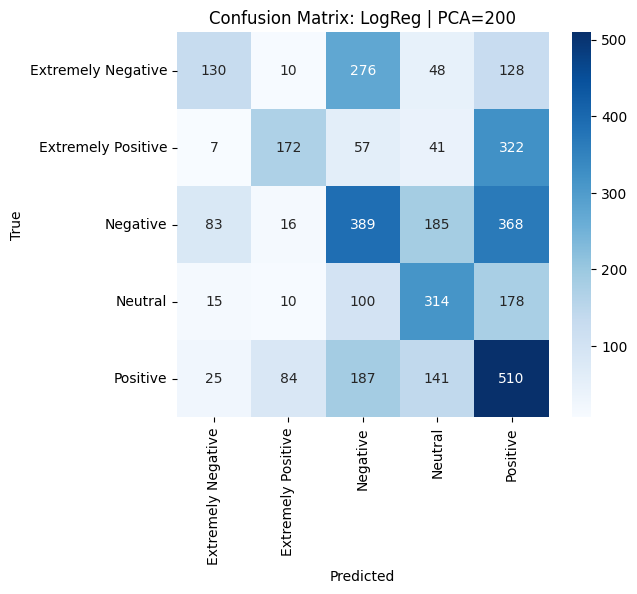

Classification report:

                    precision    recall  f1-score   support

Extremely Negative       0.50      0.22      0.31       592
Extremely Positive       0.59      0.29      0.39       599
          Negative       0.39      0.37      0.38      1041
           Neutral       0.43      0.51      0.47       617
          Positive       0.34      0.54      0.42       947

          accuracy                           0.40      3796
         macro avg       0.45      0.39      0.39      3796
      weighted avg       0.43      0.40      0.39      3796



In [14]:
best_entry = max(results, key=lambda x: x['accuracy'])
print("Найкраща модель:", best_entry['model'], "| PCA:", best_entry['pca_n'], "| accuracy:", best_entry['accuracy'])

best_fname = f"pipeline_{best_entry['model']}_pca_{best_entry['pca_n']}.joblib"
pipe_best = joblib.load(best_fname)

y_pred_best = pipe_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix: {best_entry['model']} | PCA={best_entry['pca_n']}")
plt.show()

print("Classification report:\n")
print(classification_report(y_test, y_pred_best, target_names=le.classes_, zero_division=0))


# Частина 9 — Функція для прогнозу нового твіта та збереження остаточної моделі


In [15]:
def predict_new_tweet(text, pipeline, label_encoder):
    """
    Приймає сирий текст, проганяє той самий pipeline (включно з Word2Vec та PCA, якщо є) 
    та повертає мітку у вигляді рядка.
    """
    pred_idx = pipeline.predict([text])[0]
    return label_encoder.inverse_transform([pred_idx])[0]

example_tweet = "Got my COVID vaccine today — feeling positive and relieved!"
pred_label = predict_new_tweet(example_tweet, pipe_best, le)
print(f"Приклад: '{example_tweet}' -> передбачення: {pred_label}")

final_model_fname = "final_best_pipeline.joblib"
joblib.dump(pipe_best, final_model_fname)
print("Фінальний пайплайн збережено як:", final_model_fname)


Приклад: 'Got my COVID vaccine today — feeling positive and relieved!' -> передбачення: Positive
Фінальний пайплайн збережено як: final_best_pipeline.joblib
